In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
np.set_printoptions(suppress=True)

<h1>Section 1</h1>

Just looking at the data and seeing what's doing on. Here is some stuff I found about the csv files.

<h4>atbats.csv</h4>

- <code>pitcher_id</code>: This has the pitcher id. In the player_names.csv, this is the <code>id</code> column.
- <code>batter_id</code>: This has the batter id. In the player_names.csv, this is the <code>id</code> column.
- <code>ab_id</code>: This is the id of the at bat. In the pitches.csv, this is the <code>ab_id</code> column.
- <code>g_id</code>: This is the id of the game.

<h4>Read in the data</h4>

In [11]:
# Read in data
pitches = pd.read_csv('csv_data/pitches.csv')
names = pd.read_csv('csv_data/player_names.csv')
at_bat = pd.read_csv('csv_data/atbats.csv')

# Create column in names with full name.
names['full_name'] = names['first_name'] + ' ' + names['last_name']

<h4>Merge the data to get pitcher_id/full_name linked up with the pitches they threw</h4>

In [27]:
# Merge pitches and at_bats together.
pitches_merge = pitches.merge(at_bat, on='ab_id', validate='m:1')

# Merge pitches_merge and names together
pitches_merge = pitches_merge.merge(names, left_on='pitcher_id', right_on='id')
pitches_merge.drop(['last_name', 'first_name'], axis=1, inplace=True)
# pitches_merge.set_index('pitcher_id', inplace=True)
pitches_merge.head(5)

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,id,full_name
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,201500001,1,1,0,L,452657,L,True,452657,Jon Lester
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,201500001,1,1,0,L,452657,L,True,452657,Jon Lester
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,201500001,1,1,0,L,452657,L,True,452657,Jon Lester
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,201500001,1,1,0,L,452657,L,True,452657,Jon Lester
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,201500001,1,1,0,L,452657,L,True,452657,Jon Lester


<h4>Create json file of pitchers full_name and their pitch distribution</h4>

In [63]:
# Get all possible unique pitchers
all_pitchers = pitches_merge.full_name.unique().tolist()

# Create variables
pitch_distributions = dict()

# Iterate through all unique pitchers, getting their distribution of pitches (set up like json). Will look like this:
# {'name': 
#         {'pitch_keys': [keys corresponding to pitches],
#          'pitch_dist' : [distribution of pitches (same order as keys)]}
# }
# Iterate through all pitchers
for pitch in all_pitchers:
    # Get a pitcher subset
    subset = pitches_merge.loc[pitches_merge.full_name == pitch]

    # Get the distribution
    dist = subset['pitch_type'].value_counts() / np.sum(subset['pitch_type'].value_counts())

    # Create the inner dictionary (pitch_keys and pitch_dist) and add it to main dictionary with the key as the pitchers name.
    pitch_distributions[pitch] = {'pitch_keys': dist.index.tolist(), 'pitch_dist' : dist.values.tolist()}

<h4>(View <code>pitch_distributions</code> as a json file for funsies)</h4>

In [75]:
# j = json.load([pitch_distributions])
j = json.dumps(pitch_distributions, indent=4)
print(j)

{
    "Jon Lester": {
        "pitch_keys": [
            "FF",
            "FC",
            "CU",
            "SI",
            "CH",
            "PO"
        ],
        "pitch_dist": [
            0.44896173124353567,
            0.23908027687166838,
            0.14201607128649854,
            0.10144005091892752,
            0.06826318720661946,
            0.00023868247275041769
        ]
    },
    "Adam Wainwright": {
        "pitch_keys": [
            "CU",
            "FC",
            "SI",
            "FF",
            "CH",
            "EP",
            "IN",
            "PO"
        ],
        "pitch_dist": [
            0.2747901771837115,
            0.2695057506994094,
            0.26468759714019274,
            0.1521603978862294,
            0.03372707491451663,
            0.0024867889337892445,
            0.002175940317065589,
            0.00046627292508548337
        ]
    },
    "Phil Coke": {
        "pitch_keys": [
            "FF",
            "FT",
      

<h4>Figuring out how to randomly select from distributions</h4>

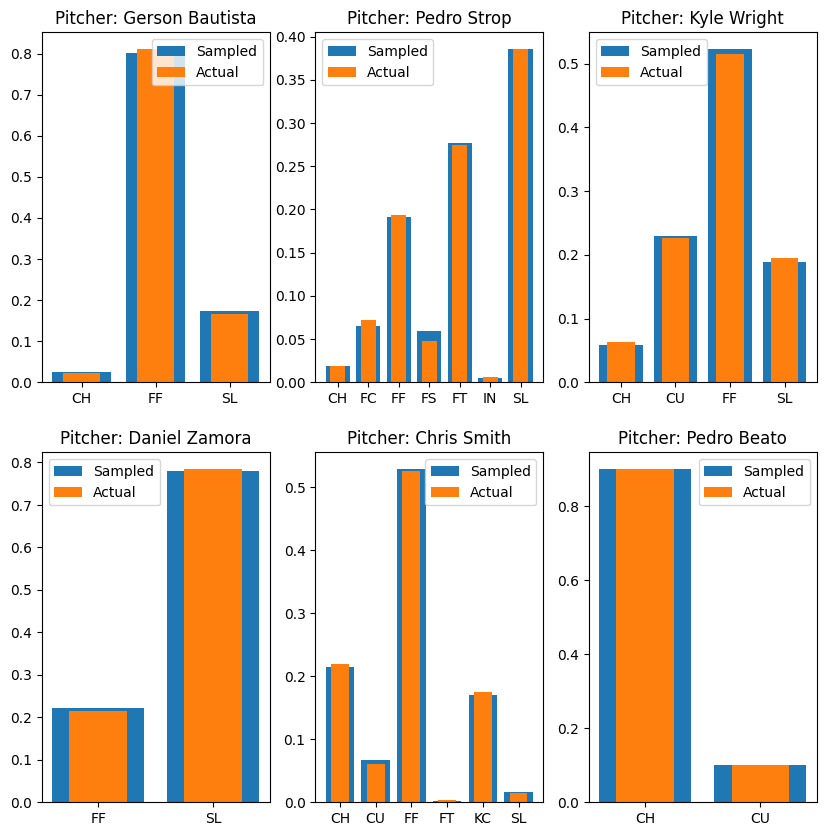

In [115]:
list_of_pitchers = list(pitch_distributions.keys())

# Initilize subplots for better viewing.
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(10,10), dpi=100)
r, c = 0, 0
for i in range(rows*cols):
    # Randomly select a pitcher
    randomly_selected_pitcher = np.random.choice(list_of_pitchers)

    # Get that pitchers distribution.
    randomly_selected_pitch = np.random.choice(pitch_distributions[randomly_selected_pitcher]['pitch_keys'], 
                                            p=pitch_distributions[randomly_selected_pitcher]['pitch_dist'],
                                            size=2500)

    # To ensure that things are working the way they are supposed to, randomly sample pitch types a ton and make sure the law
    # of large numbers kicks in.
    vals, counts = np.unique(randomly_selected_pitch, return_counts=True)
    ax[r, c].bar(vals, counts/np.sum(counts), label='Sampled')
    ax[r, c].bar(pitch_distributions[randomly_selected_pitcher]['pitch_keys'],
            pitch_distributions[randomly_selected_pitcher]['pitch_dist'],
            width=0.5, label='Actual')
    ax[r,c].legend()
    ax[r,c].set_title(f'Pitcher: {randomly_selected_pitcher}')

    c += 1
    if c == cols:
        r += 1
        c = 0

plt.show()
